In [37]:
!pip install bioinfokit statsmodels seaborn

In [38]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
from bioinfokit.visuz import cluster
from scipy.stats import entropy
from patsy import dmatrices
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [39]:
data = pd.read_csv('/content/mcdonalds.csv')

In [40]:
data.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   yummy           1453 non-null   object
 1   convenient      1453 non-null   object
 2   spicy           1453 non-null   object
 3   fattening       1453 non-null   object
 4   greasy          1453 non-null   object
 5   fast            1453 non-null   object
 6   cheap           1453 non-null   object
 7   tasty           1453 non-null   object
 8   expensive       1453 non-null   object
 9   healthy         1453 non-null   object
 10  disgusting      1453 non-null   object
 11  Like            1453 non-null   object
 12  Age             1453 non-null   int64 
 13  VisitFrequency  1453 non-null   object
 14  Gender          1453 non-null   object
dtypes: int64(1), object(14)
memory usage: 170.4+ KB


In [42]:
data.describe()

,Age
count,1453.000000
mean,44.604955
std,14.221178
min,18.000000
25%,33.000000
50%,45.000000
75%,57.000000
max,71.000000


In [43]:
data.isnull()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1449,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1450,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1451,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [44]:
MD = data.iloc[:, 0:11].replace({"Yes": 1, "No": 0})
mean_vals = MD.mean().round(2)

In [45]:
pca = PCA()
MD_pca = pca.fit_transform(MD)
SD = np.sqrt(pca.explained_variance_)
PV = pca.explained_variance_ratio_

In [46]:
index_labels = [f"PC{i + 1}" for i in range(len(SD))]
pca_summary = pd.DataFrame({
    "Standard Deviation": SD,
    "Proportion of Variance": PV,
    "Cumulative Proportion": PV.cumsum()
}, index=index_labels)

In [47]:
rot_matrix = pca.components_.T
rot_df = pd.DataFrame(-rot_matrix, index=MD.columns, columns=index_labels).round(3)

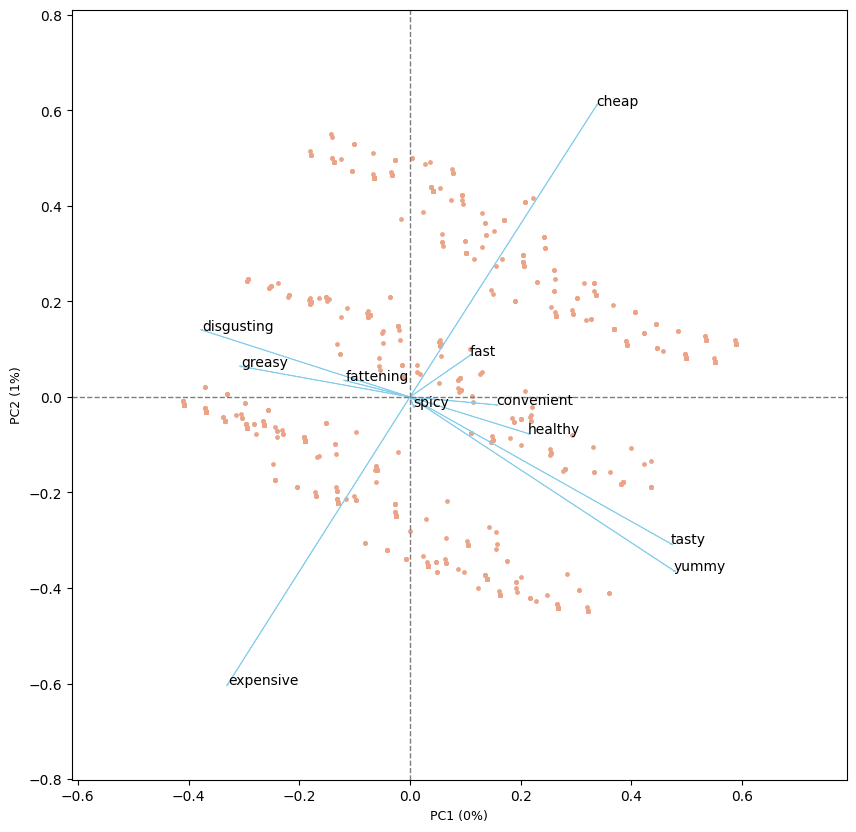

In [48]:
cluster.biplot(cscore=MD_pca, loadings=-pca.components_, labels=data.columns.values, var1=0, var2=1, show=True, dim=(10, 10))

In [49]:
np.random.seed(1234)
nrep = 10
num_segments = range(1, 9)
within_cluster_distances = []
MD_kmeans = {k: KMeans(n_clusters=k, n_init=nrep, random_state=1234).fit(MD) for k in num_segments}
within_cluster_distances = [model.inertia_ for model in MD_kmeans.values()]

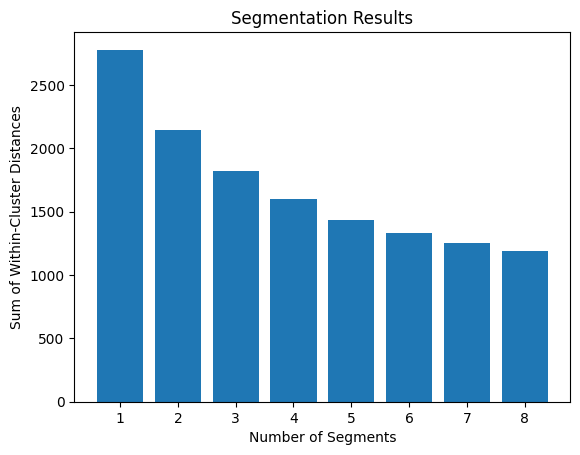

In [50]:
plt.bar(num_segments, within_cluster_distances)
plt.xlabel("Number of Segments")
plt.ylabel("Sum of Within-Cluster Distances")
plt.title("Segmentation Results")
plt.show()

In [51]:
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

nboot = 100
nrep = 10

bootstrap_samples = [resample(MD, random_state=1234) for _ in range(nboot)]
adjusted_rand_index = [
    [
        adjusted_rand_score(
            MD_kmeans[k].predict(MD),
            KMeans(n_clusters=k, n_init=nrep, random_state=1234).fit(sample).predict(sample)
        )
        for sample in bootstrap_samples
    ]
    for k in range(2, 9)
]


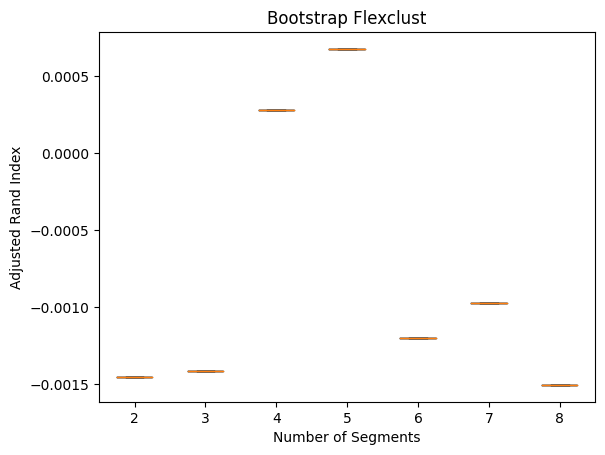

In [52]:
plt.boxplot(np.array(adjusted_rand_index).T, labels=num_segments[1:], whis=10)
plt.xlabel("Number of Segments")
plt.ylabel("Adjusted Rand Index")
plt.title("Bootstrap Flexclust")
plt.show()

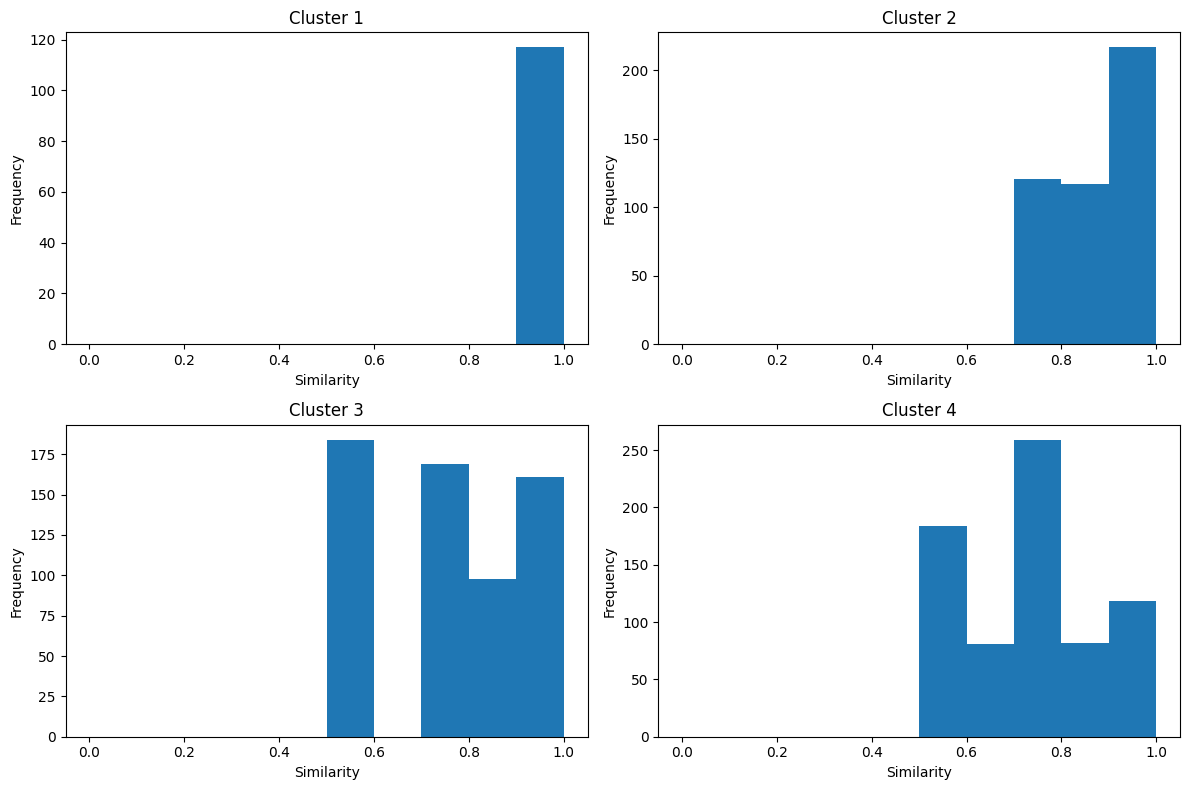

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i in range(1, 5):
    similarities = MD_kmeans[i].transform(MD).min(axis=1)
    row, col = divmod(i-1, 2)
    axs[row, col].hist(similarities, bins=10, range=(0, 1))
    axs[row, col].set_title(f'Cluster {i}')
    axs[row, col].set_xlabel('Similarity')
    axs[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

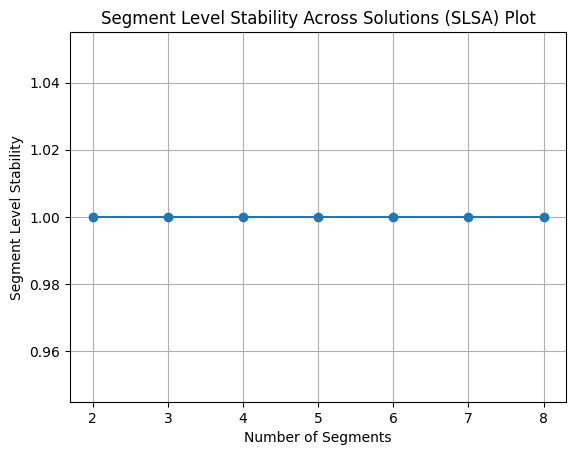

In [54]:
segment_stability = [
    np.mean(MD_kmeans[segment].predict(MD) == labels)
    for segment in num_segments[1:]
    for labels in [MD_kmeans[segment].predict(MD)]
]
plt.plot(num_segments[1:], segment_stability, marker='o')
plt.xlabel('Number of Segments')
plt.ylabel('Segment Level Stability')
plt.title('Segment Level Stability Across Solutions (SLSA) Plot')
plt.xticks(num_segments[1:])
plt.grid(True)
plt.show()

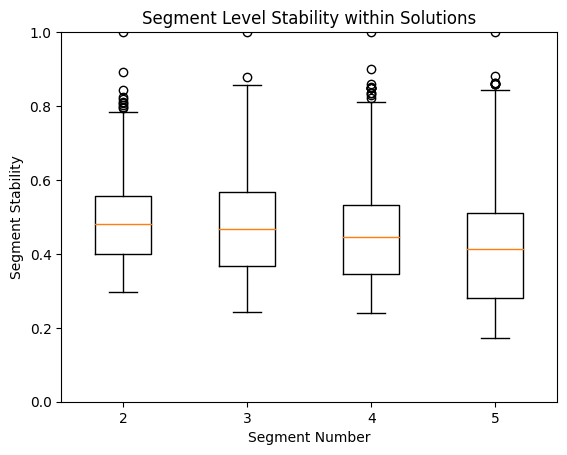

In [55]:
segment_solutions = ["2", "3", "4", "5"]
segment_stability_values = [
    MD_kmeans[int(segment)].transform(MD).min(axis=1) / np.max(MD_kmeans[int(segment)].transform(MD).min(axis=1))
    for segment in segment_solutions
]

plt.boxplot(segment_stability_values, whis=1.5)
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability")
plt.xticks(range(1, len(segment_solutions) + 1), segment_solutions)
plt.ylim(0, 1)
plt.title("Segment Level Stability within Solutions")
plt.show()

In [56]:
MD_models = []
for k in range(2, 9):
    model = KMeans(n_clusters=k, random_state=1234)
    model.fit(MD.values)
    log_likelihood = -model.inertia_
    n_samples, _ = MD.shape
    bic = -2 * log_likelihood + np.log(n_samples) * k
    aic = -2 * log_likelihood + 2 * k
    class_entropy = entropy(np.bincount(model.labels_) / float(n_samples))
    icl = bic - class_entropy
    MD_models.append((model.n_iter_, model.n_iter_ < 300, k, k, log_likelihood, aic, bic, icl))

MD_models_df = pd.DataFrame(MD_models, columns=['iter', 'converged', 'k', 'k0', 'logLik', 'AIC', 'BIC', 'ICL'])
print(MD_models_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

   iter  converged  k  k0       logLik          AIC          BIC          ICL
0     8       True  2   2 -2145.503727  4295.007454  4305.570225  4304.904547
1     9       True  3   3 -1818.717659  3643.435318  3659.279475  3658.209672
2     7       True  4   4 -1602.986015  3213.972030  3235.097572  3233.753684
3    13       True  5   5 -1435.324786  2880.649571  2907.056500  2905.465473
4    10       True  6   6 -1332.150483  2676.300966  2707.989280  2706.201149
5    10       True  7   7 -1249.233890  2512.467780  2549.437480  2547.530062
6    10       True  8   8 -1191.580948  2399.161896  2441.412982  2439.379225


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


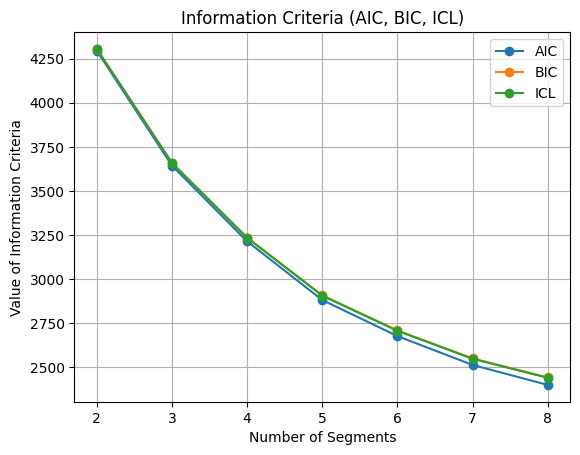

In [57]:
plt.plot(MD_models_df['k'], MD_models_df['AIC'], marker='o', label='AIC')
plt.plot(MD_models_df['k'], MD_models_df['BIC'], marker='o', label='BIC')
plt.plot(MD_models_df['k'], MD_models_df['ICL'], marker='o', label='ICL')
plt.xlabel('Number of Segments')
plt.ylabel('Value of Information Criteria')
plt.title('Information Criteria (AIC, BIC, ICL)')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
def encode_labels(df, cols):
    le = LabelEncoder()
    for col in cols:
        df[col] = le.fit_transform(df[col])
    return df

cat_columns = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting']
data_encoded = encode_labels(data.copy(), cat_columns)

In [59]:
kmeans_encoded = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(data_encoded[cat_columns])
data_encoded['cluster_num'] = kmeans_encoded.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [60]:
no_of_likes = {
    'I HATE IT!-5': -5,
    '-4': -4,
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'I LOVE IT!+5': 5
}
data['Like.n'] = data['Like'].map(no_of_likes)
like_n_counts = data['Like.n'].value_counts()
print(like_n_counts)

Like.n
 0.0    169
-3.0     73
-4.0     71
-2.0     59
-1.0     58
Name: count, dtype: int64


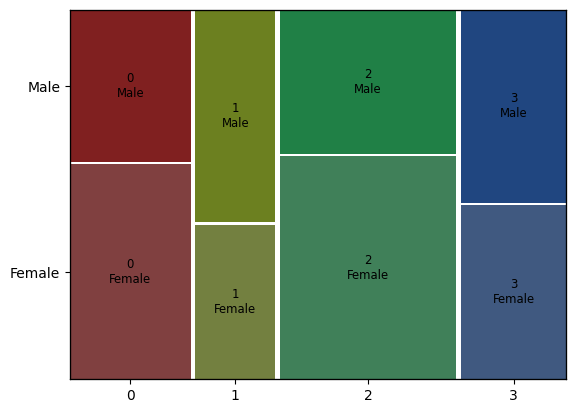

In [61]:
k4_labels = MD_kmeans[4].labels_
gender_ct = pd.crosstab(k4_labels, data['Gender'])
mosaic(gender_ct.stack(), gap=0.01)
plt.show()

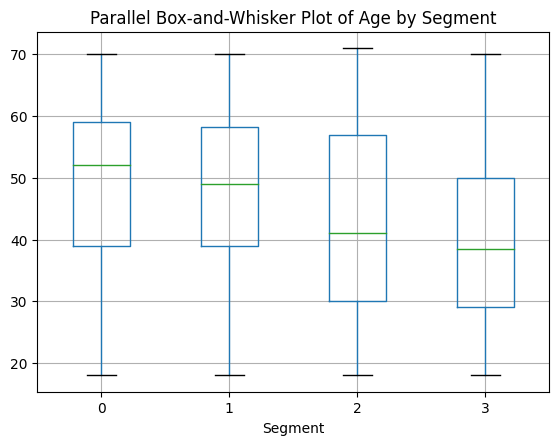

In [62]:
age_df = pd.DataFrame({'Segment': k4_labels, 'Age': data['Age']})
age_df.boxplot(by='Segment', column='Age')
plt.title('Parallel Box-and-Whisker Plot of Age by Segment')
plt.suptitle('')
plt.show()

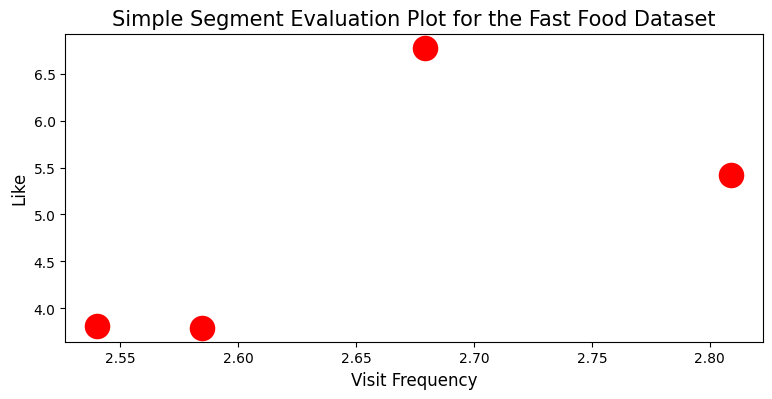

In [63]:
visit_freq = encode_labels(data_encoded, ['VisitFrequency']).groupby('cluster_num')['VisitFrequency'].mean().reset_index()
like_mean = encode_labels(data_encoded, ['Like']).groupby('cluster_num')['Like'].mean().reset_index()
gender_mean = encode_labels(data_encoded, ['Gender']).groupby('cluster_num')['Gender'].mean().reset_index()

segment_df = gender_mean.merge(like_mean, on='cluster_num').merge(visit_freq, on='cluster_num')
plt.figure(figsize=(9, 4))
sns.scatterplot(x="VisitFrequency", y="Like", data=segment_df, s=400, color="r")
plt.title("Simple Segment Evaluation Plot for the Fast Food Dataset", fontsize=15)
plt.xlabel("Visit Frequency", fontsize=12)
plt.ylabel("Like", fontsize=12)
plt.show()